# Credit VAR of a Swap

The goal of the project is to compute the Credit VAR (95th percentile) of a swap in which the counterparty might default. The input parameters are:

* The par rate of a set of Overnight Index Swaps (i.e. their market quotation)
* A set of forward libor rates and their fixing dates
* The static data of the swap (nominal, start date, maturity, underlying libor tenor, etc..). The fixed rate of the swap is such that if there was no counterparty risk, the product would be traded at par. You are requested to compute it.
* A set of survival probabilities for the risky counterparty
* The recovery rate for this swap (i.e. the fraction of the market value that it is expected to recover in case of default).
* The volatility of the swap rate, which is assumed to be constant through time (the swap rate is lognormal with fixed volatility)

The swap starts today and the horizon for the VAR calculation is before any future payments. 

The requested VAR is today’s value at risk, i.e. the 95th percentile of the discounted loss distribution function.

Numerical results must be presented to the examining committee during a presentation in which the candidates will also explain the theoretical framework for credit risk evaluation.




In [1]:
from datetime import date

In [2]:
pricing_date = date(2019, 10, 31)

In [3]:
survival_probabilities = [
    {'date': date(2020, 12, 20), 'ndp': 0.972159727015014},
    {'date': date(2021, 12, 20), 'ndp': 0.942926329174406},
    {'date': date(2022, 12, 20), 'ndp': 0.913448056250137},
    {'date': date(2024, 12, 20), 'ndp': 0.855640452819766},
    {'date': date(2029, 12, 20), 'ndp': 0.732687779675469},
    {'date': date(2039, 12, 20), 'ndp': 0.539046016487758},
]

In [4]:
ois_quotes = [
    {'maturity': 1, 'rate': 0.00106},
    {'maturity': 2, 'rate': 0.00114},
    {'maturity': 3, 'rate': 0.00115},
    {'maturity': 4, 'rate': 0.00117},
    {'maturity': 5, 'rate': 0.00119},
    {'maturity': 6, 'rate': 0.00121},
    {'maturity': 7, 'rate': 0.00122},
    {'maturity': 8, 'rate': 0.00124},
    {'maturity': 9, 'rate': 0.00128},
    {'maturity': 10, 'rate': 0.00131},
    {'maturity': 11, 'rate': 0.00135},
    {'maturity': 12, 'rate': 0.00138},
    {'maturity': 15, 'rate': 0.00152},
    {'maturity': 18, 'rate': 0.00166},
    {'maturity': 21, 'rate': 0.00184},
    {'maturity': 24, 'rate': 0.00206},
    {'maturity': 36, 'rate': 0.00344},
    {'maturity': 48, 'rate': 0.00543},
    {'maturity': 60, 'rate': 0.00756},
    {'maturity': 72, 'rate': 0.00967},
    {'maturity': 84, 'rate': 0.01162},
    {'maturity': 96, 'rate': 0.0134},
    {'maturity': 108, 'rate': 0.01502},
    {'maturity': 120, 'rate': 0.01649},
    {'maturity': 132, 'rate': 0.01776},
    {'maturity': 144, 'rate': 0.01888},
    {'maturity': 180, 'rate': 0.02137},
    {'maturity': 240, 'rate': 0.02322},
    {'maturity': 300, 'rate': 0.02389},
    {'maturity': 360, 'rate': 0.02416},
]

In [5]:
euribor_6m = [
    {'date': date(2019, 10, 31), 'rate': 0.005},
    {'date': date(2020, 4, 30), 'rate': 0.0058},
    {'date': date(2020, 10, 30), 'rate': 0.0066},
    {'date': date(2021, 4, 30), 'rate': 0.0074},
    {'date': date(2021, 10, 30), 'rate': 0.0082},
    {'date': date(2022, 4, 30), 'rate': 0.009},
    {'date': date(2022, 10, 30), 'rate': 0.0098},
    {'date': date(2023, 4, 30), 'rate': 0.0106},
    {'date': date(2023, 10, 30), 'rate': 0.0114},
    {'date': date(2024, 4, 30), 'rate': 0.0122},
    {'date': date(2024, 10, 30), 'rate': 0.013},
    {'date': date(2025, 4, 30), 'rate': 0.0138},
    {'date': date(2025, 10, 30), 'rate': 0.0146},
    {'date': date(2026, 4, 30), 'rate': 0.0154},
    {'date': date(2026, 10, 30), 'rate': 0.0162},
    {'date': date(2027, 4, 30), 'rate': 0.017},
    {'date': date(2027, 10, 30), 'rate': 0.0178},
    {'date': date(2028, 4, 30), 'rate': 0.0186},
    {'date': date(2028, 10, 30), 'rate': 0.0194},
    {'date': date(2029, 4, 30), 'rate': 0.0202},
    {'date': date(2029, 10, 30), 'rate': 0.021},
    {'date': date(2030, 4, 30), 'rate': 0.0218},
    {'date': date(2030, 10, 30), 'rate': 0.0226},
    {'date': date(2031, 4, 30), 'rate': 0.0234},
    {'date': date(2031, 10, 30), 'rate': 0.0242},
    {'date': date(2032, 4, 30), 'rate': 0.025},
    {'date': date(2032, 10, 30), 'rate': 0.0258},
    {'date': date(2033, 4, 30), 'rate': 0.0266},
    {'date': date(2033, 10, 30), 'rate': 0.0274},
    {'date': date(2034, 4, 30), 'rate': 0.0282},
]

In [6]:
irs_to_price = {
    'nominal': 100e6, 
    'libor_tenor': 6,
    'fixed_leg_frequency': 12,
    'maturity': 120
}

credit_var_date = date(2020, 1, 31)
recovery = 0.4
volatility = 0.2
mc_runs = 10000
percentile = 0.95

In [7]:
from finmarkets import ForwardRateCurve

pillars = []
rates = []
for e in euribor_6m:
    pillars.append(e['date'])
    rates.append(e['rate'])
    
libor_curve = ForwardRateCurve(pillars, rates)

In [8]:
from finmarkets import OvernightIndexSwap, generate_swap_dates

pillar_dates = [pricing_date]
swaps=[]
for quote in ois_quotes:
    swap = OvernightIndexSwap(
        100e6,
        generate_swap_dates(pricing_date, quote['maturity']),
        quote['rate']        
    )
    
    swaps.append(swap)
    pillar_dates.append(swap.payment_dates[-1])
    
pillar_dates = sorted(pillar_dates)

In [9]:
from finmarkets import DiscountCurve

def objective_function(x):    
    curve = DiscountCurve(pricing_date, pillar_dates, x)
    
    sum_sq = 0.0
    for swap in swaps:
        sum_sq += swap.npv(curve) ** 2
        
    return sum_sq

In [10]:
from scipy.optimize import minimize

x0 = [0.5 for i in range(len(pillar_dates))]
bounds = [(0.01, 100.0) for i in range(len(pillar_dates))]
bounds[0] = (1.0, 1.0)

result = minimize(objective_function, x0, bounds=bounds)

In [11]:
print (result)
print (objective_function(x0))
print (objective_function(result.x))

      fun: 6.561222679982968
 hess_inv: <31x31 LbfgsInvHessProduct with dtype=float64>
      jac: array([  5.79533148e+09,  -6.11416340e-01,  -1.02210560e+00,
        -1.02002513e+00,  -2.29282726e-01,  -4.21489510e-01,
         2.38069475e-01,   2.97073477e-01,  -5.43240652e-01,
         4.44265780e-01,  -8.33293257e-01,  -1.09130767e+00,
         9.87086946e-01,   9.95737715e-01,   6.46644338e-01,
        -4.08022061e-02,   4.03090246e+00,   5.22987289e+00,
         3.57629242e+00,   1.91212068e+00,   9.02650932e-01,
         9.36993327e-01,   2.68969549e+00,  -2.77300849e-02,
         1.84280680e+00,   8.60156124e-01,   4.02244407e+00,
         2.54872106e+00,  -4.00618099e+00,  -1.45631898e+00,
        -2.40547777e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1120
      nit: 13
   status: 0
  success: True
        x: array([ 1.        ,  0.99991167,  0.99980687,  0.99970619,  0.9996069 ,
        0.9994978 ,  0.99938865,  0.99927868,  0.99916369,  0.

In [12]:
discount_curve = DiscountCurve(pricing_date, pillar_dates, result.x)

In [13]:
from finmarkets import InterestRateSwap

random_fixed_rate = 1
irs_random = InterestRateSwap(credit_var_date, irs_to_price['nominal'], 
                              random_fixed_rate, 
                              irs_to_price['libor_tenor'],
                              irs_to_price['maturity']) 
                                                        
swap_rate = irs_random.swap_rate(discount_curve, libor_curve)

In [14]:
irs = InterestRateSwap(credit_var_date, irs_to_price['nominal'], 
                       swap_rate, 
                       irs_to_price['libor_tenor'],
                       irs_to_price['maturity']) 

In [15]:
from finmarkets import CreditCurve
from datetime import date

pillar_dates = [pricing_date]
ndps = [1.0]

for quote in survival_probabilities:  
        pillar_dates.append(quote['date']) 
        ndps.append(quote['ndp'])

credit_curve = CreditCurve(pillar_dates, ndps)
#print (credit_curve.ndp(date(2039, 12, 20)))

In [16]:
#from dateutil.relativedelta import relativedelta

#maturity_date = pricing_date + relativedelta(months=irs_to_price['maturity'])
#delta = (maturity_date - pricing_date).days

#adate = pricing_date
#date_list = []
#for _ in range(delta):
#    date_list.append(adate)
#    adate += relativedelta(days=1)

#pd_cdf = []
#for i in range(len(date_list)):
#    pd_cdf.append(credit_curve.ndp(date_list[0]) - credit_curve.ndp(date_list[i]))
    
#from matplotlib import pyplot as plt
#plt.plot(pd_cdf)
#plt.show()

In [17]:
#from numpy import random, percentile, log
#from scipy.optimize import root

#def invert(seed, pd_cdf):
#    for ipd, pd in enumerate(pd_cdf):
#        if pd > seed: 
#            return ipd

#time_horizon = (credit_var_date - pricing_date).days

#default_dates = []
#seeds = random.uniform(0, pd_cdf[92], 10000)
#for s in seeds:
#    days = invert(s, pd_cdf)
#    default_dates.append(days)

In [32]:
import numpy as np
import math

n_scenarios = 1000000
np.random.seed(1)
payoffs = []
npv_mc_list = []

maturity = max(irs.fixed_leg_dates[-1], irs.floating_leg_dates[-1])
S = swap_rate
A = irs.annuity(discount_curve)
T = (credit_var_date - pricing_date).days/365

for i_scenario in range(n_scenarios):
    
    if np.random.uniform(0,1) > credit_curve.ndp(credit_var_date):
        default = True
    else:
        default = False
    
    # simulates the swap rate in this scenario
    rnd = np.random.normal()
    S_simulated = S * math.exp(-0.5 * volatility * volatility * T + 
                               volatility * math.sqrt(T) * rnd)
    
    # calculate the swap NPV in this scenario
    swap_npv = irs.notional * (S_simulated - irs.fixed_rate)*(A/discount_curve.df(credit_var_date))  
    
    if default and swap_npv > 0:
        swap_npv = swap_npv * recovery
    
        # adds the payoff of the swap, in this scenario, to the list
        payoffs.append(swap_npv)

#print (payoffs)

Credit Var: 13579110.71 Eur


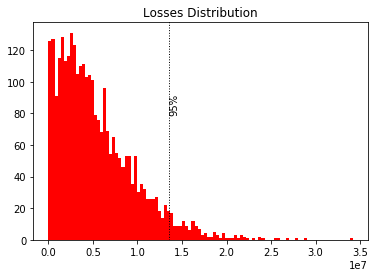

In [35]:
from matplotlib import pyplot as plt
#At the 95% of confidence interval

a = np.array(payoffs)
credit_var = np.percentile(a, 95)

print('Credit Var: {:.2f} Eur'.format(credit_var))

plt.title("Losses Distribution")
plt.hist(a, bins=100, facecolor='red')
plt.axvline(x = credit_var, ymin=0, ymax=90,linestyle=':',linewidth=1, color = 'k')
plt.text(credit_var, 80, r'95%', fontsize=10, rotation=90, color='k')

plt.show()